# Part 0:
## Import necessary packages

In [99]:
import math
import os
import subprocess
import time

import gurobipy as gp
import hmmlearn.hmm as hmm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from gurobipy import *
from scipy.stats import skew

# Part 1:
## Download all ticker data

In [107]:
datadir = os.path.join(os.getcwd(),'..','data')
sp500_price_file = os.path.join(datadir, 'sp500_individual_prices.csv')
sp500_returns_file = os.path.join(datadir, 'sp500_individual_returns.csv')

In [110]:
price_df = pd.read_csv(sp500_price_file, index_col=0)
returns_df = pd.read_csv(sp500_returns_file, index_col=0)

# Part 2:
## Get the current market regime

In [34]:
os.chdir(os.path.join(os.getcwd()))

df = yf.Ticker("^GSPC").history(period="max")
df['logret'] = np.log(df.Close)-np.log(df.Close.shift(1))
X = df.logret
X.iloc[0] = 0
X = np.array(X).reshape(-1, 1)

model = hmm.GMMHMM(n_components=4, covariance_type="full", algorithm="map")
model_fit = model.fit(X)
output = model_fit.predict(X)

plot_df = df[["Close","logret"]]
plot_df["State"] = output

plot_df.to_csv("regimes_prices.csv")

C:\Users\richa\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


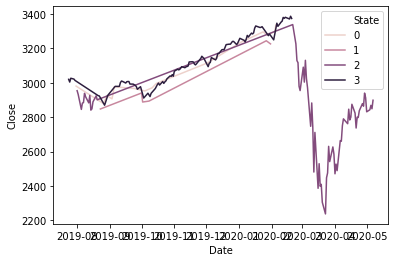

In [35]:
pdf = plot_df.iloc[-200:,:]
ax = sns.lineplot(x=pdf.index, y="Close", data=pdf, hue="State")
plt.show()

In [68]:
fpath = os.path.join(os.getcwd(), 'hmm.R')
subprocess.call(["C:/Program Files/R/R-3.6.2/bin/Rscript.exe", fpath])

0

In [72]:
regime_file = os.path.join(datadir, 'pprobsGSPC.csv')
regimes = pd.read_csv(regime_file, index_col=0)
regimes_list = ["Level2"]+list(regimes.State_Name)
len(regimes_list)

In [94]:
plot_df["State_Names"] = regimes_list

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


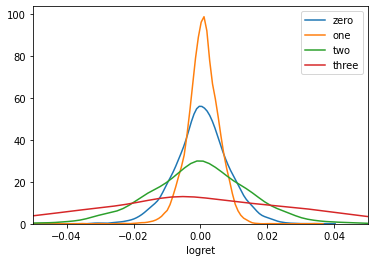

In [96]:
zero = plot_df[plot_df.State_Names == "Level1"]
one = plot_df[plot_df.State_Names == "Level2"]
two = plot_df[plot_df.State_Names == "Level3"]
three = plot_df[plot_df.State_Names == "Level4"]
sns.distplot(zero.logret, hist=False, kde=True, label="zero")
sns.distplot(one.logret, hist=False, kde=True, label="one")
sns.distplot(two.logret, hist=False, kde=True, label="two")
sns.distplot(three.logret, hist=False, kde=True, label="three")
plt.xlim(-.05, .05)
plt.legend()

In [103]:
# Invoke Gurobi to solve the LP
def solve_lp(methnum, annualized_r, sigma, inflation_factor):

    # Model setup
    gm = gp.Model("Konno")

    # Create the data
    mu, B, T, assets, returns = get_data()
    
    r_expected = (((1+(annualized_r/100))**(1/252))-1)*100 # Set the expected return here.  Asssumes 252 trading days per year
    rj = mu # means are denoted by r in Konno's paper
    n = len(assets)  # number of assets
    alpha = 1 # Set value for alpha
    time_inverse = 1/(T-1) # Constant for minimization of objective function
    
    w = (T-1)*np.sqrt(2/math.pi)*sigma*inflation_factor
    
    rho_1 = r_expected-1
    rho_2 = r_expected-2
    
    min_prop = 0.2

    # --------------------------------------------------------------------------
    # IMPLEMENT LP Formulation Here
    # --------------------------------------------------------------------------
    
    # Add vars
    u = gm.addVars(T)  # For calulating Skewness
    v = gm.addVars(T)  # For calculating Skewness
    x = gm.addVars(n)  # Weights of each asset
    XI = gm.addVars(T) # For constraining
    H = gm.addVars(T)  # For constraining
    
    # Set the Objective
    gm.setObjective(time_inverse*(quicksum(u[t] for t in range(T)) + alpha*quicksum(v[t] for t in range(T))), GRB.MINIMIZE)
    
#     y = gm.addVars(n, vtype=GRB.BINARY)
#     gm.addConstrs(y[j] >= x[j] for j in range(n))
#     gm.addConstrs(min_prop*y[j] <= x[j] for j in range(n))
    
    # Add constraints
    gm.addConstrs((u[t]+quicksum(returns[t,j]*x[j] for j in range(n))) >= rho_1 for t in range(T))
    gm.addConstrs((v[t]+quicksum(returns[t,j]*x[j] for j in range(n))) >= rho_2 for t in range(T))
    
    gm.addConstrs(XI[t]-H[t]-quicksum(returns[t,j]*x[j] for j in range(n)) == r_expected for t in range(T))
    gm.addConstr(quicksum(rj[j]*x[j] for j in range(n)) == r_expected)

    gm.addConstr(quicksum(XI[t]+H[t] for t in range(T)) <= w)
    gm.addConstr(quicksum(x[j] for j in range(n)) == 1)
    gm.addConstrs(x[j] >= 0 for j in range(n))
    gm.addConstrs(u[t] >= 0 for t in range(T))
    gm.addConstrs(v[t] >= 0 for t in range(T))
    gm.addConstrs(XI[t] >= 0 for t in range(T))
    gm.addConstrs(H[t] >= 0 for t in range(T))

        
    
    # Solve the model
    meth = methnum
    gm.setParam('Method', meth)
    gm.update()
    
    gm.setParam('LogToConsole', 1)
    gm.setParam('LogFile', "method_{}.log".format(meth))
    
    gm.optimize()
    
    
    weights = []
    for k in x.keys():
        weights.append(x[k].x)
    weights = np.array(weights)
    #print(weights)
    print(np.mean(returns.dot(weights)))
    print(np.std(returns.dot(weights)))
    print(skew(returns.dot(weights)))
    
    return(gm, skew(returns.dot(weights)))

# Generate the data
def get_data():
    B = 100000
    
    returns = returns_df.iloc[-1500:,:]
    
    T = returns_df.shape[0]
    assets = returns.columns
    
    mu = returns.mean()
    
    returns = returns.to_numpy()
    
    return(mu, B, T, assets, returns)

In [104]:
start_time = time.time()
out, skw = solve_lp(2, 15,1,1)
time.time()-start_time

GurobiError: Invalid argument to LinExpr multiplication

In [111]:
returns_df.tail()

MMM  ABT  ABBV  ABMD  ACN  ATVI  ADBE  AMD  AAP  AES  ...  WYNN  \
Date                                                              ...         
2020-05-07  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...   0.0   
2020-05-07  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...   0.0   
2020-05-07  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...   0.0   
2020-05-07  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...   0.0   
2020-05-07  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...   0.0   

            XEL  XRX  XLNX  XYL  YUM  ZBRA  ZBH  ZION  ZTS  
Date                                                        
2020-05-07  0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  
2020-05-07  0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  
2020-05-07  0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  
2020-05-07  0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  
2020-05-07  0.0  0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  

[5 rows x 503 columns]